In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = pd.read_csv("data/network_traffic/kddcup.data.combined.csv")

In [2]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target', 'attack_class'],
      dtype='object')

In [3]:
# Encode categorical features using OneHotEncoder
categorical_features = ['protocol_type', 'service', 'flag']
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Label encode the target variable
label_encoder = LabelEncoder()
df_encoded['target'] = label_encoder.fit_transform(df['target'])
df_encoded['attack_class'] = label_encoder.fit_transform(df['attack_class'])

In [4]:
# Split data into features (X) and target (y)
X = df_encoded.drop(['target', 'attack_class'], axis=1)
y = df_encoded['attack_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=404, stratify=y)

In [5]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=404, n_jobs=-1)
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print(f"model score on training data: {rf.score(X_train, y_train)}")
print(f"model score on testing data: {rf.score(X_test, y_test)}")

model score on training data: 0.9999991250841013
model score on testing data: 0.9999584901294972


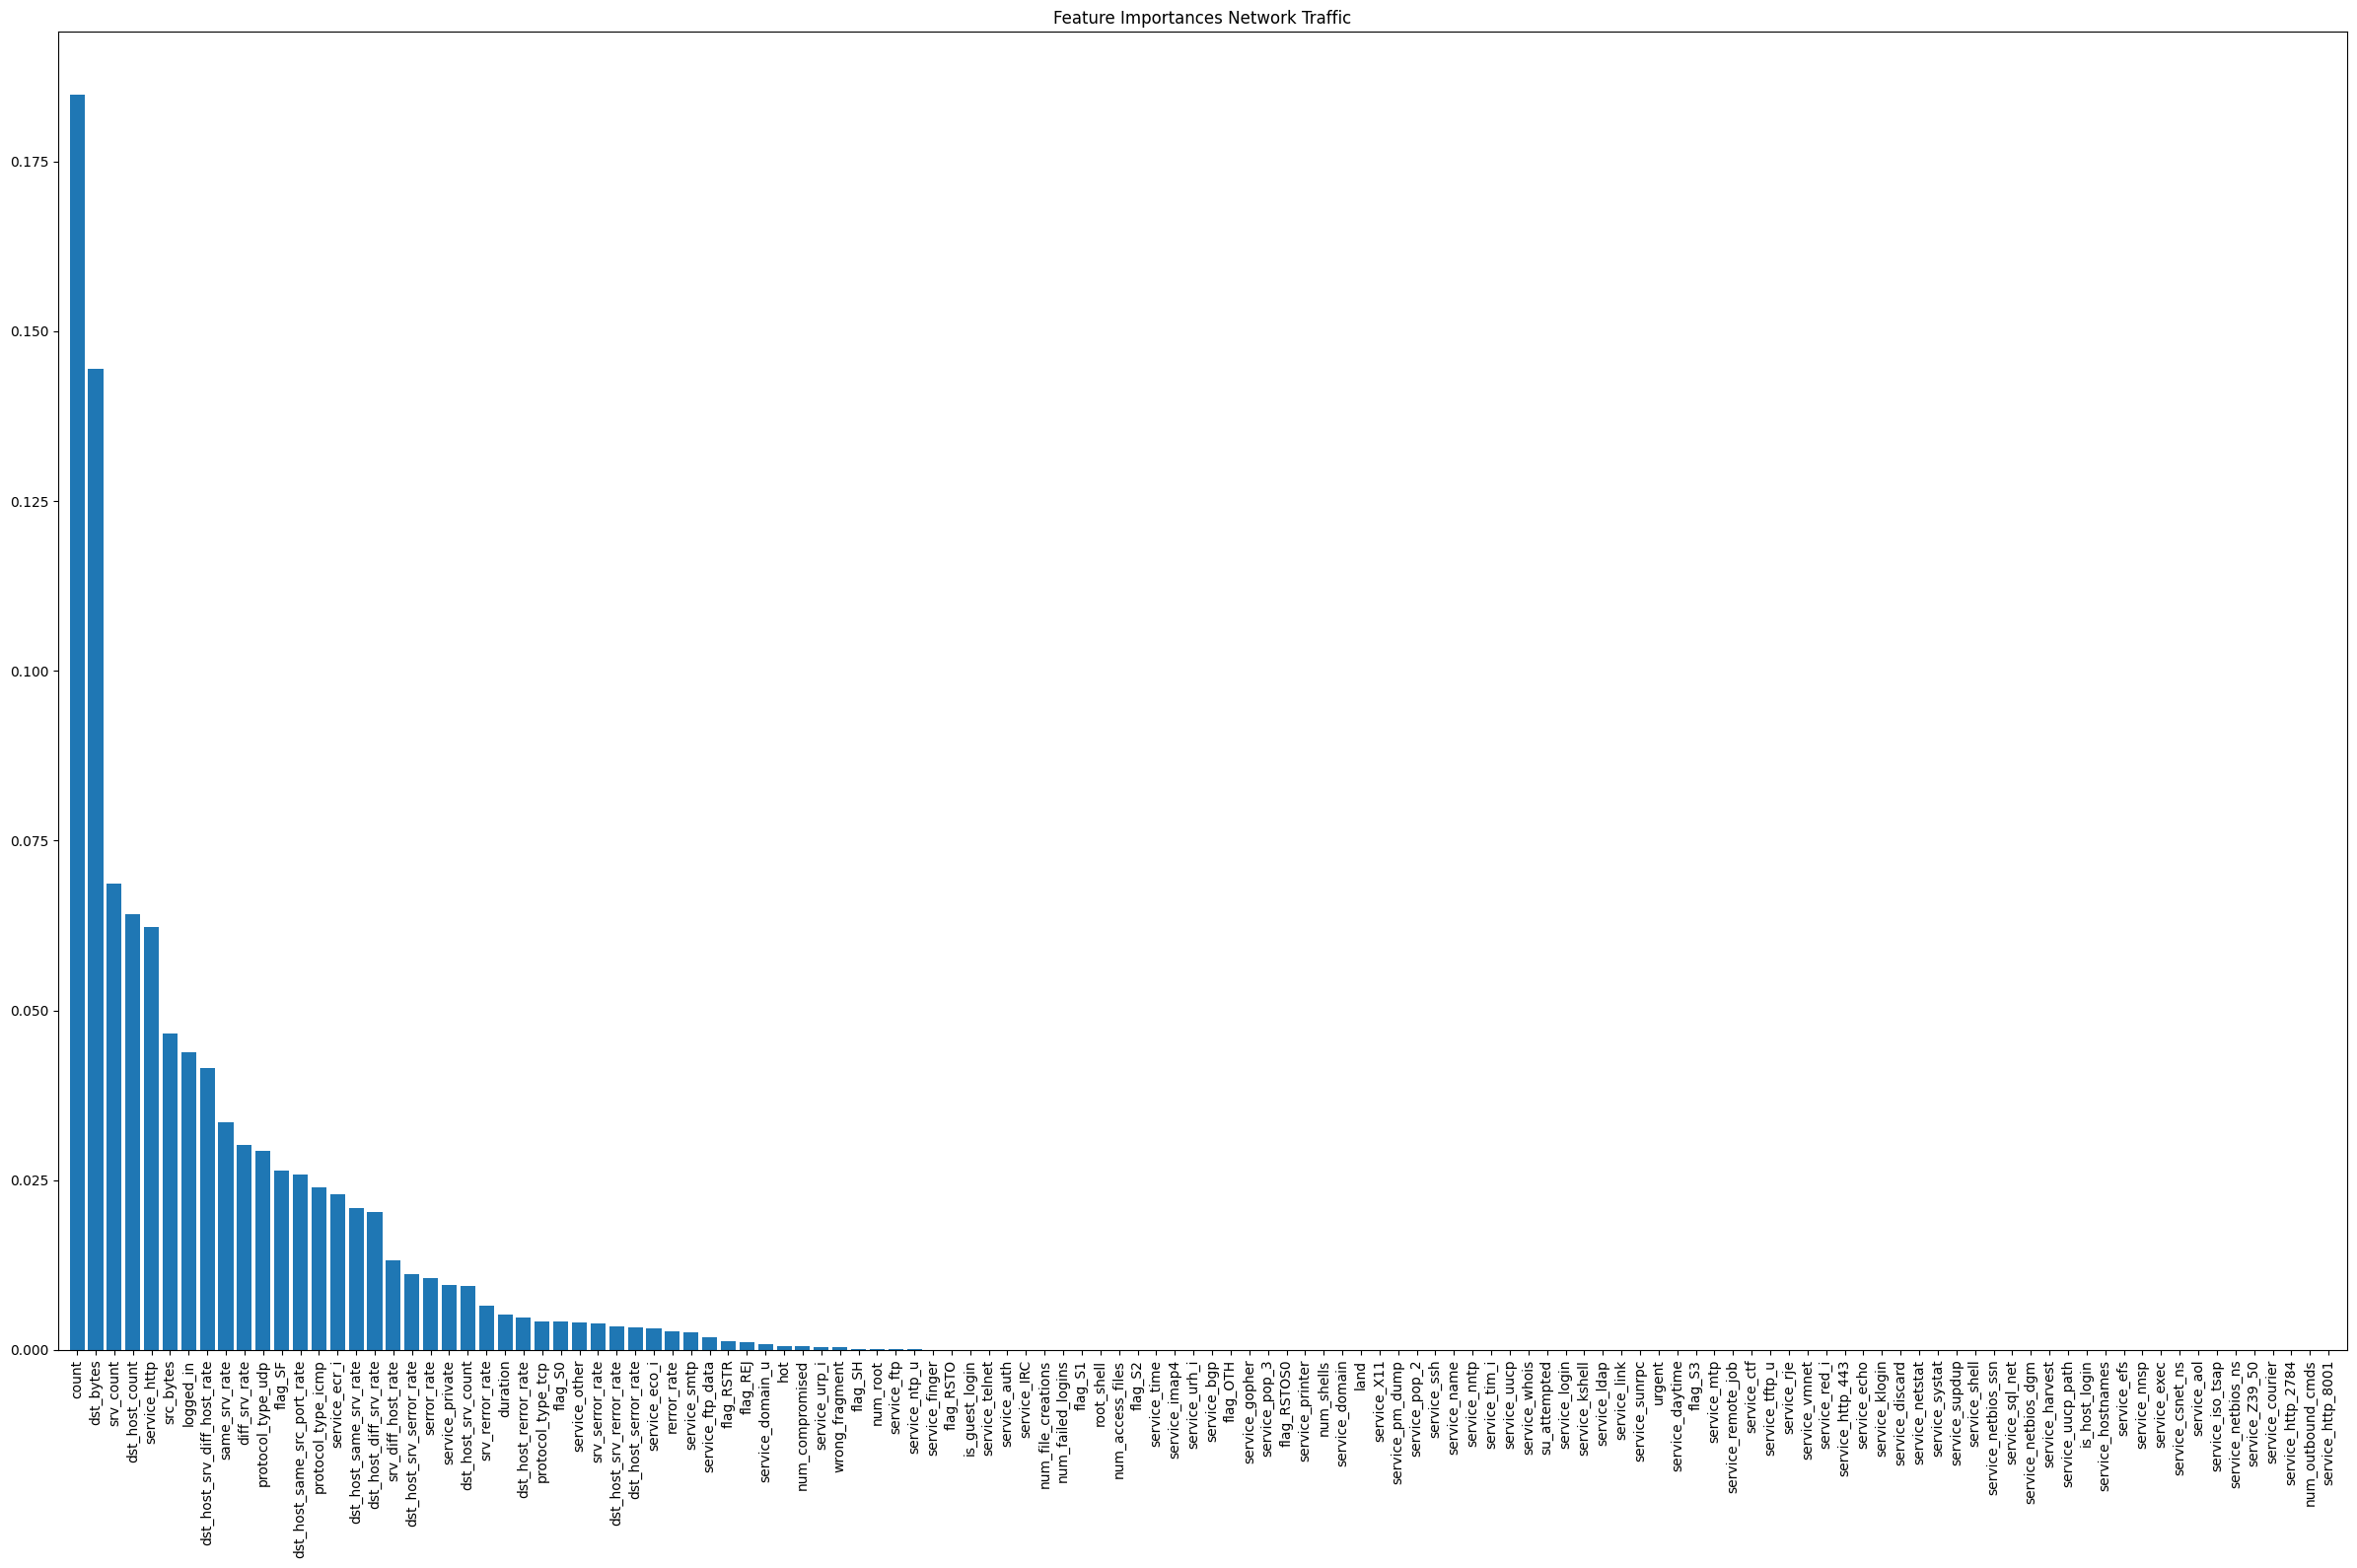

In [8]:
plt.figure(figsize=(24, 16))
plt.title("Feature Importances Network Traffic")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [11]:
# Evaluate model performance with and without specific features
def evaluate_model(features):
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    rf.fit(X_train_subset, y_train)
    y_pred = rf.predict(X_test_subset)
    acc = accuracy_score(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, beta=10, average='macro')
    return acc, fbeta

# All features
all_features = X.columns.tolist()
all_acc, all_fbeta = evaluate_model(all_features)
print(f"All features - Accuracy: {all_acc}, F-beta Score (beta=10): {all_fbeta}")

# Identify least important features
least_important_features = [X_train.columns[indices[-i-1]] for i in range(20)]  # Adjust the number as needed
print("Least important features:", least_important_features)

# Without least important features
important_features = [f for f in X.columns if f not in least_important_features]
important_acc, important_fbeta = evaluate_model(important_features)
print(f"Without least important features - Accuracy: {important_acc}, F-beta Score (beta=10): {important_fbeta}")
print("Important features:", important_features)

All features - Accuracy: 0.9999584901294972, F-beta Score (beta=10): 0.9157005738871657
Least important features: ['service_http_8001', 'num_outbound_cmds', 'service_http_2784', 'service_courier', 'service_Z39_50', 'service_netbios_ns', 'service_iso_tsap', 'service_aol', 'service_csnet_ns', 'service_exec', 'service_nnsp', 'service_efs', 'service_hostnames', 'is_host_login', 'service_uucp_path', 'service_harvest', 'service_netbios_dgm', 'service_sql_net', 'service_netbios_ssn', 'service_shell']
Without least important features - Accuracy: 0.9999591706191776, F-beta Score (beta=10): 0.927010959015988
Important features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',